In [1]:
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image

In [2]:
file_path = "test.zip"
output = file_path
if not os.path.exists("Test Set/"):
    gdown.download("https://drive.google.com/uc?id=1W94tVozlrHMY_SWE-45TvWT5PqQjElxc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)

In [3]:
gender_img_height = 378
gender_img_width = 378
emotions_img_height = 224
emotions_img_width = 224
gender_class_names = ["Man", "Woman"]
emotions_class_names = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]

In [4]:
#Load the Model
file_path = "test.zip"
if not os.path.exists("Gender Model/"):
    gdown.download("https://drive.google.com/uc?id=1easVnhBN9o1s60_eAyl8CGj_LHuPoXgc", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
gender_model = keras.models.load_model('Gender Model/')

#Load the Model
file_path = "test.zip"
if not os.path.exists("Emotions Model/"):
    gdown.download("https://drive.google.com/uc?id=1zwwyyd0CZZBDOYt6vSliejyq7NrGbRsT", file_path)
    gdown.extractall(file_path)
    if os.path.exists(file_path):
        os.remove(file_path)
emotions_model = keras.models.load_model('Emotions Model/')

In [5]:
def prepare_img(img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    return images

def write_on_box(frame, gender_class_names, gender_classes, x, y, h, sorted_dict):
    c = 10
    cv2.putText(frame, gender_class_names[np.where(gender_classes > 0.5, 1,0)[0][1]], (x, y+h+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    for key, value in sorted_dict.items():    
        cv2.putText(
            frame, 
            str(key) + " " + str(value)[:-5], 
            (x, y-c), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9, 
            (36,255,12), 
            2
        )
        c += 30

Woman 'Happy': 0.9999882, 'Neutral': 0.98944855
Neutral 0.98944855
Neutral 0.98944855


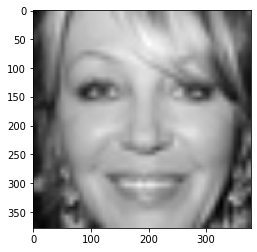

In [55]:
## Load and Predict an image
img = image.load_img("Test Set/333.png", color_mode = "grayscale")

gender_img = cv2.resize(np.float32(img), (gender_img_height, gender_img_width))
gender_classes = gender_model.predict(prepare_img(gender_img))

emotions_img = cv2.resize(np.float32(img), (emotions_img_height, emotions_img_width))
emotions_classes = emotions_model.predict(prepare_img(emotions_img))

index = list(np.where(np.where(emotions_classes > 0.8, 1, 0)[0] == 1)[0])
dictionary = dict()
sorted_dict = dict()
for i in index:
    dictionary[emotions_class_names[i]] = emotions_classes[0][i]
sorted_keys = sorted(dictionary, key=dictionary.get, reverse=True)
for w in sorted_keys:
    sorted_dict[w] = dictionary[w]
    
print(gender_class_names[np.where(gender_classes > 0.5, 1,0)[0][1]] + " " + str(sorted_dict)[1:-1])

for key, value in sorted_dict.items():
    print(k, v)

plt.imshow(gender_img, cmap="gray")

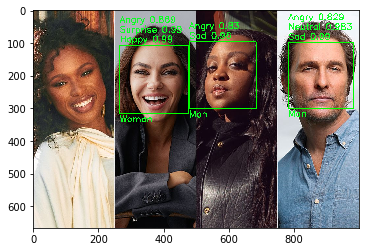

In [7]:
img = cv2.imread("test.jpg")

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(img, 1.2, 4)
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    resiz = cv2.resize(np.float32(g[y:y+h, x:x+w]), (emotions_img_height, emotions_img_width))
    clas = emotions_model.predict(prepare_img(resiz))
    gender_img = cv2.resize(np.float32(g[y:y+h, x:x+w]), (gender_img_height, gender_img_width))
    gender_classes = gender_model.predict(prepare_img(gender_img))
    index = list(np.where(np.where(clas > 0.8, 1, 0)[0] == 1)[0])
    dictionary = dict()
    sorted_dict = dict()
    for i in index:
        dictionary[emotions_class_names[i]] = clas[0][i]
    sorted_keys = sorted(dictionary, key=dictionary.get, reverse=True)
    for w in sorted_keys:
        sorted_dict[w] = dictionary[w]
    c = 10
    cv2.putText(img, gender_class_names[np.where(gender_classes > 0.5, 1,0)[0][1]], (x, y+h+25), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
    for key, value in sorted_dict.items():    
        cv2.putText(
            img, 
            str(key) + " " + str(value)[:-5], 
            (x, y-c), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9, 
            (36,255,12), 
            2
        )
        c += 30
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [7]:
cap = cv2.VideoCapture(0)

if (cap.isOpened() == False): 
    print("Unable to read camera feed")

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

skip_frames = 30
cur_frames = 0
 
while(True):
    ret, frame = cap.read()
    
    if ret == True:
        process_frame = cur_frames % skip_frames == 0
        gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            if process_frame:
                gender_img = cv2.resize(np.float32(gray[y:y+h, x:x+w]), (gender_img_height, gender_img_width))
                gender_classes = gender_model.predict(prepare_img(gender_img))
                resized = cv2.resize(gray[y:y+h, x:x+w], (emotions_img_height,emotions_img_width))
                emotions_classes = emotions_model.predict(prepare_img(resized))
                dictionary = dict()
                sorted_dict = dict()
                index = list(np.where(np.where(emotions_classes > 0.8, 1, 0)[0] == 1)[0])
                for i in index:
                    dictionary[emotions_class_names[i]] = emotions_classes[0][i]
                sorted_keys = sorted(dictionary, key=dictionary.get, reverse=True)
                for w in sorted_keys:
                    sorted_dict[w] = dictionary[w]
                write_on_box(frame, gender_class_names, gender_classes, x, y, h, sorted_dict)
                cv2.imshow('frame', frame)
                cur_frames += 1
            else:
                write_on_box(frame, gender_class_names, gender_classes, x, y, h, sorted_dict)
                cv2.imshow('frame', frame)
                cur_frames += 1
        
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            break
    else:
        break 

cap.release()
cv2.destroyAllWindows()